In [1]:
# import package
import requests
from datetime import date,timedelta
from urllib.request import urlopen
from dateutil import rrule
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import json
import time

%matplotlib inline

## 抓取資料

理想上好像該從台灣證交所抓資料 https://www.twse.com.tw/ , 但是一次抓大量資料的話IP被暫時拒絕連線。就算使用 `twstock` 也是會被擋(看了[git](https://github.com/mlouielu/twstock) 原始檔也是從證交所爬資料)。所以改成從yahoo抓

參考資料
[Finlab Python新手教學(1)用爬蟲爬全球股價](https://www.finlab.tw/%E7%94%A8%E7%88%AC%E8%9F%B2%E7%88%AC%E5%85%A8%E4%B8%96%E7%95%8C%E8%82%A1%E5%83%B9/)

In [2]:
# 設定起始時間, 結束時間, 以及股票代號
stock_id = str(2330) #台積電
start_time = datetime.datetime(2018,1,1,0,0).strftime('%s')
end_time = datetime.datetime(2020,1,8,0,0).strftime('%s')

site = ("https://query1.finance.yahoo.com/v7/finance/download/"+stock_id+".TW?period1="+start_time+"&period2="+end_time+"&interval=1d&events=history&crumb=hP2rOschxO0")
response = requests.post(site)
print(response.text[:200])

Date,Open,High,Low,Close,Adj Close,Volume
2018-01-02,231.500000,232.500000,231.000000,232.500000,213.912537,18055269
2018-01-03,236.000000,238.000000,235.500000,237.000000,218.052811,29308091
2018-01-


資料量很大, 最好將讀進來的資料轉成csv存起來，之後就針對儲存的檔案處理資料

In [3]:
with open('./res/stock_daily_price.csv','w') as f:
    f.writelines(response.text)

dataframe = pd.read_csv('./res/stock_daily_price.csv')
dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,231.5,232.5,231.0,232.5,213.912537,18055269
1,2018-01-03,236.0,238.0,235.5,237.0,218.052811,29308091
2,2018-01-04,240.0,240.0,236.5,239.5,220.352921,29096613
3,2018-01-05,240.0,240.0,238.0,240.0,220.812943,22438255
4,2018-01-08,242.0,242.5,240.5,242.0,222.653061,20233692


不想影響到原始資料，copy一份出來獨立處裡資料

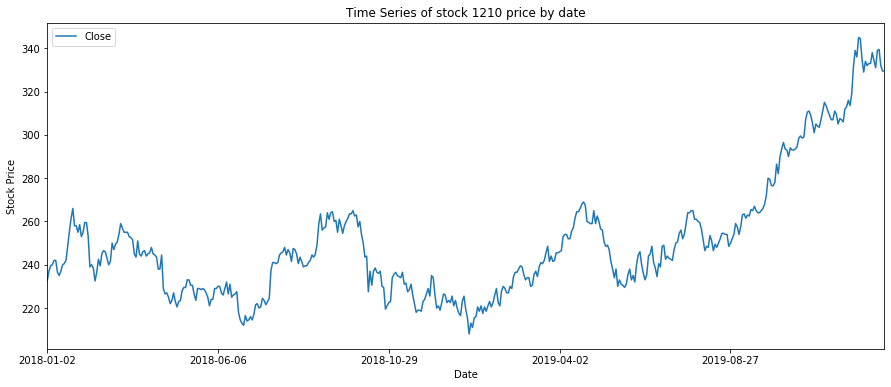

In [4]:
df = dataframe.copy()
df.dropna()

df.plot( x='Date', y='Close', figsize=(15,6))
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Time Series of stock 1210 price by date');

## 額外練習

看到時間序列，想試試看套Anomaly Detection 找出時間序列異常值
https://github.com/vxld014/S-H-ESD

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import t
from matplotlib import pyplot

def seasonal_mean(x, freq):
  """
  Returns the mean of the timeseries for each period in x.
  x    : List, array, or series containing the time series
  freq : Int that gives the number of periods per cycle (7 for week, 12 for monthly, etc)
  """
  return np.array([pd.Series(x[i::freq]).mean(skipna=True) for i in range(freq)])

def ts_S_Md_decomposition(x, freq):
    """
    Decomposes the timeseries using a modified STL method:Rx = X - Sx - X^~.
    Rx : Residuals
    X  : Original time series
    Sx : Seasonality component (average value per period)
    X^~: Median of original timeseries
    x    : List, array, or series containing the time series 
    freq : Int that gives the number of periods per cycle (7 for week, 12 for monthly, etc)  
    """
    nobs = len(x)
  
    # Seasonality
    period_averages = seasonal_mean(x, freq)
    seasonal = np.tile(period_averages, nobs // freq + 1)[:nobs]
    
    # Median
    med = np.tile(pd.Series(x).median(skipna=True), nobs)

    # Residuals
    res = np.array(x) - seasonal - med

    return {"observed": np.array(x), "seasonal": seasonal, "median":med, "residual":res}


def ts_decomposition_plot(x):
    """
    Plots the timeseries decomposition for x.
    """
    fig, ax = pyplot.subplots(4, 1, sharex=True) # 4 graphs arranged in rows
    ax[0].plot(x["observed"])
    ax[0].set_ylabel("Observed")
    ax[1].plot(x["median"])
    ax[1].set_ylabel("Median")
    ax[2].plot(x["seasonal"])
    ax[2].set_ylabel("Seasonal")
    ax[3].plot(x["residual"])
    ax[3].set_ylabel("Residual")
    display(pyplot.show())
    pyplot.gcf().clear()  
  
  
def esd_test_statistics(x, hybrid=True):
    """
    Compute the location and dispersion sample statistics used to carry out the ESD test.
    """
    if hybrid:
        location = pd.Series(x).median(skipna=True) # Median
        dispersion = np.median(np.abs(x - np.median(x))) # Median Absolute Deviation
    else:  
        location = pd.Series(x).mean(skipna=True) # Mean
        dispersion = pd.Series(x).std(skipna=True) # Standard Deviation

    return location, dispersion    


def esd_test(x, freq, alpha=0.95, ub=0.499, hybrid=True):
    """
    Carries out the Extreme Studentized Deviate(ESD) test which can be used to detect one or more outliers present in the timeseries
    x      : List, array, or series containing the time series
    freq   : Int that gives the number of periods per cycle (7 for week, 12 for monthly, etc)
    alpha  : Confidence level in detecting outliers
    ub     : Upper bound on the fraction of datapoints which can be labeled as outliers (<=0.499)
    hybrid : Whether to use the robust statistics (median, median absolute error) or the non-robust versions (mean, standard deviation) to test for anomalies
    """
    nobs = len(x)
    if ub > 0.4999:
        ub = 0.499
    k = max(int(np.floor(ub * nobs)), 1) # Maximum number of anomalies. At least 1 anomaly must be tested.
    res_tmp = ts_S_Md_decomposition(x, freq)["residual"] # Residuals from time series decomposition

    # Carry out the esd test k times  
    res = np.ma.array(res_tmp, mask=False) # The "ma" structure allows masking of values to exclude the elements from any calculation
    anomalies = [] # returns the indices of the found anomalies
    for i in range(1, k+1):
        location, dispersion = esd_test_statistics(res, hybrid) # Sample statistics
        tmp = np.abs(res - location) / dispersion
        idx = np.argmax(tmp) # Index of the test statistic
        test_statistic = tmp[idx] 
        n = nobs - res.mask.sum() # sums non masked values
        critical_value = (n - i) * t.ppf(alpha, n - i - 1) / np.sqrt((n - i - 1 + np.power(t.ppf(alpha, n - i - 1), 2)) * (n - i - 1)) 
        if test_statistic > critical_value:
            anomalies.append(idx)
            res.mask[idx] = True  

    return anomalies

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


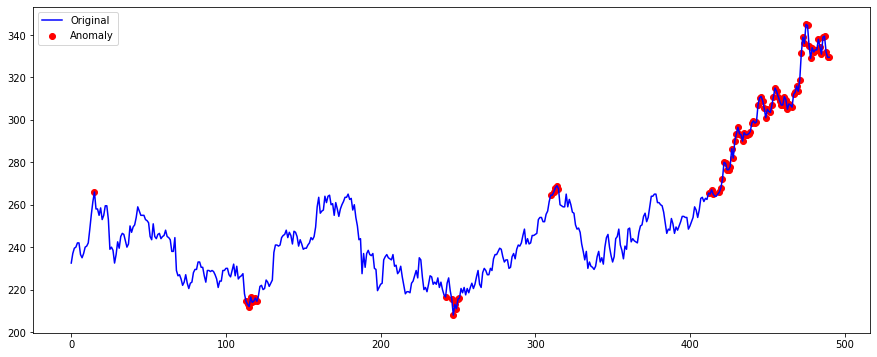

In [6]:
x = dataframe.copy()
x = x['Close']
# Use the algorithm to find anomalies
anomalies = esd_test(x, freq=7, alpha=0.95, ub=0.499, hybrid=True)

# Plot the anomalies
fig, ax = pyplot.subplots(figsize=(15,6))
ax.plot(pd.Series(x).index, x, color="blue", label = "Original")
ax.scatter(anomalies, x[anomalies], color='red', label='Anomaly')
pyplot.legend(loc="best")
pyplot.show()

## Reference

1. [python爬蟲 - 個股歷年股價資訊](https://medium.com/renee0918/python-%E7%88%AC%E5%8F%96%E5%80%8B%E8%82%A1%E6%AD%B7%E5%B9%B4%E8%82%A1%E5%83%B9%E8%B3%87%E8%A8%8A-b6bc594c8a95)
1. [TPEX / TWSE Codes](https://twstock.readthedocs.io/zh_TW/latest/quickstart.html#id2)